# Anti-resonant hollow-core fiber

Hollow-core optical fibers guide light through an air core rather than a solid glass core. This unique waveguiding provides inherent advantages like extremely low nonlinearity since the light propagates mainly through air, which allows transmitting much higher peak powers before nonlinear effects occur. Hollow fibers can also achieve lower loss limits compared to solid fibers since the core avoids material absorption and Rayleigh scattering. In addition, the ability to fill the core with specific gases allows for a range of enhanced optical interactions and sensing applications.

There are two main types of hollow-core fibers. Photonic bandgap fibers rely on a periodic microstructured cladding to create a forbidden gap of wavelengths that cannot propagate, thereby confining light to the core defect. Alternatively, anti-resonant fibers utilize non-periodic cladding features that are simply designed to be anti-resonant or anti-reflective against the core mode at the wavelength of interest.

This notebook demonstrates how to analyze the supported modes of an anti-resonant hollow core fiber consisting of a single ring of non-touching hollow tubes surrounding the central air core. The design is adopted from `Mattia Michieletto, Jens K. Lyngsø, Christian Jakobsen, Jesper Lægsgaard, Ole Bang, and Thomas T. Alkeskjold, "Hollow-core fibers for high power pulse delivery," Opt. Express 24, 7103-7119 (2016)`. 

<img src="img/hollow_core_fiber.png" width="400" alt="Schematic of the hollow-core fiber">

Tidy3D offers two different mode solvers. The first is integrated within the Tidy3D Python package, allowing users to execute mode solving tasks on their local computers quickly without incurring any FlexCredit expenses. The second mode solver runs exclusively on the cloud. Users do need to pay a small amount of FlexCredits to run it. However, the main advantage of the cloud mode solver is that it implements the sub-pixel averaging scheme so the results are more accurate. For larger mode solving computation, it is also faster since advanced hardware is used in the computation. To learn more about the mode solvers, please refer to the dedicated [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/ModeSolver/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tidy3d as td
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

## Simulation Setup

Define basic parameters. We aim to solve for the fiber modes at 1030 nm. The core diameter (largest inscribed circle touching the tubes) `D` is 30 μm. The thickness of the tube wall `t` is 750 nm. The outer diameter of the tubes `d` and the number of tubes `n` can be tuned to optimize the confinement loss. In this notebook, we fix `d` to `0.6 * D` and `n` to 7. 

In [2]:
lda0 = 1.03  # wavelength
D = 30  # core diameter
t = 0.75  # tube wall thickness
n = 7  # number of tubes
d = 0.6 * D  # outer diameter of the tubes

angles = np.linspace(0, 2 * np.pi, n, endpoint=False)  # angles of the tube centers
x0s = np.sin(angles) * (D + d) / 2  # x coordinates of the tube centers
y0s = np.cos(angles) * (D + d) / 2  # y coordinates of the tube centers

The fiber is made of silica glass with a refractive index of 1.45. Here we define the silica and air mediums.

In [3]:
n_silica = 1.45  # refractive index of silica

# define silica and air mediums
silica = td.Medium(permittivity=n_silica**2)
air = td.Medium()

To create the hollow-core fiber structures, we first create a core region made of air with radius `D/2 + d`. The tubes are constructred by two concentric cylinders, one larger cylinder made of silica with radius `d/2` and one smaller cylinder made of air with radius `d/2 - t`. The combination of these structures with the background medium set to silica will result in the desired fiber cross section.

In [4]:
lz = 1  # dummy length in the z direction

# create a core region made of air
core = td.Structure(
    geometry=td.Cylinder(center=(0, 0, 0), radius=D / 2 + d, length=lz), medium=air
)

# create outer cylinders made of silica
tubes_outer = [
    td.Structure(
        geometry=td.Cylinder(center=(x0s[i], y0s[i], 0), radius=d / 2, length=lz),
        medium=silica,
    )
    for i in range(n)
]

# create inner cylinders made of air
tubes_inner = [
    td.Structure(
        geometry=td.Cylinder(center=(x0s[i], y0s[i], 0), radius=d / 2 - t, length=lz),
        medium=air,
    )
    for i in range(n)
]

To facilitate mode solving, we will create a [Simulation]() first. In this simulation, we do not need to have sources and monitors since we do not need to run any FDTD simulations. 

It is worth noting that the cross section of the hollow-core fiber has reflection symmetry in the $x$ direction. In this example, we focus on modes with an odd symmetry by setting `symmetry=(-1,0,0)`. Modes with an even symmetry can be found in the same way. For more information regarding how symmetry works, refer to the [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Symmetry/).

In [5]:
buffer = 3 * lda0  # buffer spacing in x and y
Lx = (D + 2 * d) + buffer  # mode solving plane size in x
Ly = (D + 2 * d) + buffer  # mode solving plane size in y

# define a simulation for mode solving
sim = td.Simulation(
    size=(Lx, Ly, lz / 2),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
    structures=[core] + tubes_outer + tubes_inner,
    run_time=1e-12,
    medium=silica,
    symmetry=(-1, 0, 0),  # odd symmetry in the x direction
)

To verify the setup is correct, we can plot the permittivity distribution of the fiber cross section.

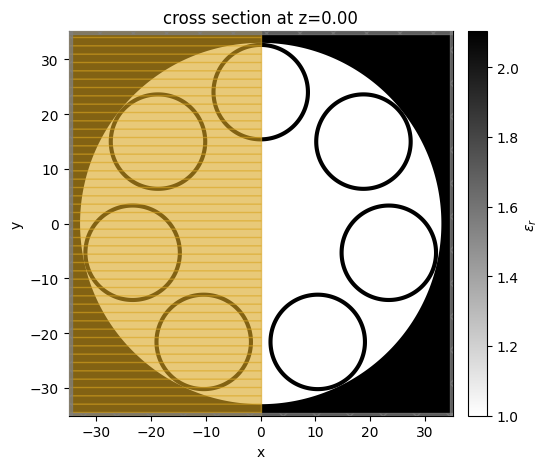

In [6]:
sim.plot_eps(z=0)
plt.show()

## Perform Mode Solving

Now we are ready to perform the mode solving. We will solve for the first 5 modes with effective indices around 1 since we are looking for modes concentrated in air. To get better accuracy, we set `precision="double"`. We are also interested in the confinement loss of the modes, which require the mode solver to use PML boundaries. By default, the mode solver uses PEC boundaries. To override it, we specify the number of PML layers to be 15 in both the $x$ and $y$ directions in this case.

In [7]:
# define the mode spec
mode_spec = td.ModeSpec(
    num_modes=5, target_neff=1, precision="double", num_pml=(15, 15)
)

# define a mode solver
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(size=(td.inf, td.inf, 0)),
    mode_spec=mode_spec,
    freqs=[td.C_0 / lda0],
)

Since the mode solving plane is very large and we need to obtain accurate results for the effective indices and losses, we run the mode solving calculation on the server instead of locally on the computer. 

In [8]:
mode_data = run_mode_solver(mode_solver)

13:41:25 Eastern Daylight Time Mode solver created with                         
                               task_id='fdve-1b8f65de-3a2e-43c7-8f01-6e76a5be733
                               5',                                              
                               solver_id='mo-e1957c34-1622-43a7-b912-5c308549414
                               5'.

Output()

Output()

13:41:27 Eastern Daylight Time Mode solver status: queued

13:41:29 Eastern Daylight Time Mode solver status: running

13:47:54 Eastern Daylight Time Mode solver status: success

Output()

## Analyze Mode Results

Plot the first 4 mode profiles. We see that the first mode is the HE$_{11}$ mode. The second and third modes are the HE$_{31}$ modes. The forth mode has the field concentrated inside the tubes and is commonly refered to as the "tube mode".

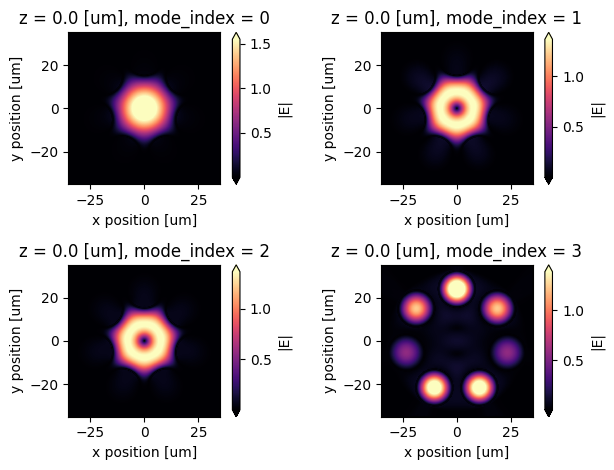

In [9]:
fig, ax = plt.subplots(2, 2, tight_layout=True)

mode_solver.plot_field("E", "abs", mode_index=0, eps_alpha=0, ax=ax[0, 0])
mode_solver.plot_field("E", "abs", mode_index=1, eps_alpha=0, ax=ax[0, 1])
mode_solver.plot_field("E", "abs", mode_index=2, eps_alpha=0, ax=ax[1, 0])
mode_solver.plot_field("E", "abs", mode_index=3, eps_alpha=0, ax=ax[1, 1])

If needed, all electric and magnetic field components can be plotted to inspect the polarization better. As a demonstration, we plot the three electric field components of the fundamental mode.

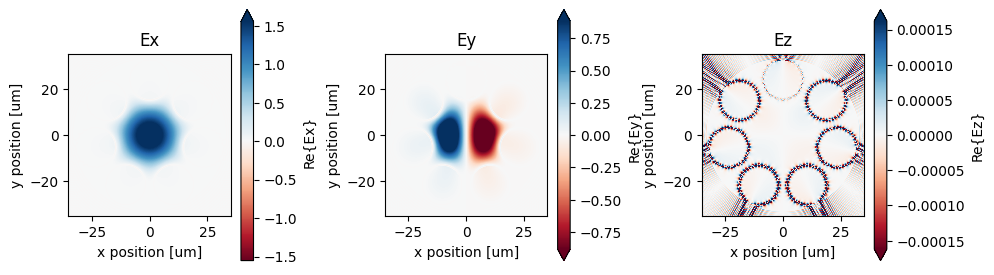

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)

mode_solver.plot_field("Ex", "real", mode_index=0, eps_alpha=0, ax=ax[0])
ax[0].set_title("Ex")
mode_solver.plot_field("Ey", "real", mode_index=1, eps_alpha=0, ax=ax[1])
ax[1].set_title("Ey")
mode_solver.plot_field("Ez", "real", mode_index=2, eps_alpha=0, ax=ax[2])
ax[2].set_title("Ez")
plt.show()

In addition, we can convert the mode data to a pandas data frame to inspect various mode properties such as the effective indices, confinement loss, and mode area.

In [11]:
mode_data.to_dataframe()

wavelength     n eff         k eff  loss (dB/cm)  \
f            mode_index                                                     
2.910606e+14 0                 1.03  0.999695  4.855479e-10      0.000257   
             1                 1.03  0.999231  1.025431e-08      0.005433   
             2                 1.03  0.999230  2.979815e-09      0.001579   
             3                 1.03  0.998863  3.812763e-06      2.020211   
             4                 1.03  0.998863  3.599941e-06      1.907446   

                         TE (Ex) fraction  wg TE fraction  wg TM fraction  \
f            mode_index                                                     
2.910606e+14 0                   0.999975        0.999679        0.999678   
             1                   0.502061        0.999192        0.999188   
             2                   0.497940        0.999915        0.998464   
             3                   0.780959        0.998749        0.998503   
             4                   0.501444        0.998766        0.998480   

                          mode area  
f            mode_index              
2.910606e+14 0           384.422999  
             1           532.370841  
             2           529.784332  
             3           517.112206  
             4           725.623557